In [2]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['a24','a','b']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'B64','c':'C80','d':'D96'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

ens='b'

In [3]:
Tpack=32; d_jk=1
# path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData/NST_f/data/NST_f_cA2.09.48_Nsgm.h5'
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_merge/Nsgm.h5'
data=yu.load(path,d=d_jk)
# assert(np.all(data['cfgs'][0]==cfgs_m2))
Njk=len(data['cfgs'][0])

loading: /capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_merge/Nsgm.h5
251/251: diags/Z3pt/srcs/Z3pt.h5_NJNpi-Nsrc=4*1                               


In [4]:
flags={
    'cc2pt':True, # average quantities related by complex conjugation for 2pt
    'cc3pt':True, # same for 3pt (Removal of vacuum expectation value requires 'cc2pt'=='cc3pt')
    'll2pt':True, # average irrep rows 'l1' and conjugated 'l2' (Parity breaking effect of tmQCD has been taken care of)
    'll3pt':True, # same for 3pt (This flag has no effect if 'll2pt'=True and spin-projection is done)
    'r2pt': True, # making 2ptMat real for the rest frame # 'll2pt' has to be real for this flag
    'remove_pi0VEV':True, 
    'remove_jVEV':True,
}

def op_remove_pi0(op):
    t=op.split(';')
    if t[-1] in ['p','n','n,pi+']:
        return False
    if t[3] not in ['N0pi0,a','N1pi0,a','N0sgm0,a','N1sgm0,a']:
        return False
    if t[3] in ['N0sgm0,a','N1sgm0,a']:
        t[3]='a'
        t[-1]={'p,sgm':'p'}[t[-1]]
        return ';'.join(t)
    if t[2] == 'G1u':
        t[2]='G1g'
        assert(t[3]=='N0pi0,a'); t[3]='a'
        assert(t[-1]=='p,pi0'); t[-1]='p'
        return ';'.join(t)

def get2pt_diag(opa,opb,diag):
    opab=f'{opa}_{opb}'
    if opab not in data['2pt'].keys() or diag not in data['2pt'][opab].keys():
        return 0
    res=data['2pt'][opab][diag].copy()
    if not flags['remove_pi0VEV']:
        return res
    if diag == 'pi0f-pi0i':
        if opa==opb and opa=='t;0,0,0;pi0':
            res -= (data['VEV']['pi0f']**2)[:,None]
        return res
    
    if 'pi0f' in diag.split('-'):
        t_opa=op_remove_pi0(opa)
        if t_opa != False:
            t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
            res -= data['2pt'][f'{t_opa}_{opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
    if 'pi0i' in diag.split('-'):
        t_opb=op_remove_pi0(opb)
        if t_opb != False:
            t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
            res -= data['2pt'][f'{opa}_{t_opb}'][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
        t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
        if t_opa != False and t_opb != False:
            t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
            res += data['2pt'][f'{t_opa}_{t_opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    return res

def get2pt(opa,opb,diags=yu.diags_all):
    res=np.zeros([Njk,Tpack],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['2pt']:
        res+=np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opab].keys() if diag in diags],axis=0)
    if opba in data['2pt']:
        diags_cc={'T', 'T-pi0f'}; 
        res+=np.conj(np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opba].keys() if diag in diags_cc and diag in diags],axis=0))
    return res

def get2ptMat(ops,diags=yu.diags_all):
    if flags['ll2pt']:
        flags['ll2pt']=False
        ops_flip=[yu.op_flipl(op) for op in ops]
        t=(get2ptMat(ops,diags=diags)+np.conj(get2ptMat(ops_flip,diags=diags)))/2
        flags['ll2pt']=True
        if ops[0].split(';')[1]=='0,0,0' and flags['r2pt']:
            t=np.real(t)
        return t
    t=np.transpose([[get2pt(opa,opb,diags) for opb in ops] for opa in ops],[2,3,0,1])
    if flags['cc2pt']:
        t=(t+np.conj(np.transpose(t,[0,1,3,2])))/2
    return t

tfs=[8,10,12,14,16,18,20]

def get3pt_diag(opa,opb,insert,diag):
    opab=f'{opa}_{opb}'
    if opab not in data['3pt'].keys() or diag not in data['3pt'][opab][insert].keys():
        return 0
    res=data['3pt'][opab][insert][diag].copy()
    if flags['remove_pi0VEV']:
        if 'pi0f' in diag.split('-'):
            t_opa=op_remove_pi0(opa)
            if t_opa != False:
                t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
                res -= data['3pt'][f'{t_opa}_{opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
        if 'pi0i' in diag.split('-'):
            t_opb=op_remove_pi0(opb)
            if t_opb != False:
                t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
                res -= data['3pt'][f'{opa}_{t_opb}'][insert][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
        if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
            t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
            if t_opa != False and t_opb != False:
                t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
                res += data['3pt'][f'{t_opa}_{t_opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if flags['remove_jVEV']:
        gm,j,tf=insert.split('_')
        t_insert='_'.join([gm,j])
        if 'j' in diag.split('-') and t_insert in ['id_j+','g5_j-']:
            t=diag.split('-'); t.remove('j'); t_diag='-'.join(t)
            res -= (get2pt_diag(opa,opb,t_diag)[:,int(tf)] * data['VEV']['j'][t_insert])[:,None]
    return res

def get3pt(opa,opb,insert,diags=yu.diags_all):
    res=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['3pt']:
        res+=np.sum([get3pt_diag(opa,opb,insert,diag) for diag in data['3pt'][opab][insert].keys() if diag in diags],axis=0)
    if opba in data['3pt']:
        t=data['3pt'][opb+'_'+opa][insert]; 
        diags_cc={'B3pt','W3pt','Z3pt','T-j', 'T-pi0f-j','T-jPf','B3pt-pi0f','W3pt-pi0f','Z3pt-pi0f'}; 
        if opab not in data['3pt'] or 'NJN-pi0f' not in data['3pt'][opab][insert]:
            diags_cc.add('NJN-pi0i')
        t_add=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)+np.sum([get3pt_diag(opb,opa,insert,diag) for diag in t.keys() if diag in diags_cc and diag in diags],axis=0)
        res+=np.conj(t_add[:,::-1])*(yu.gtCj[insert.split('_')[0]])
    return res

def get3ptMat(opas,opbs,insert,diags=yu.diags_all):
    if flags['ll3pt']:
        flags['ll3pt']=False
        opas_flip=[yu.op_flipl(op) for op in opas]; opbs_flip=[yu.op_flipl(op) for op in opbs]
        sgns=np.array([[yu.op_getl_sgn(opa)*yu.op_getl_sgn(opb) for opb in opbs] for opa in opas])
        sgns*=yu.fourCPTstar[insert.split('_')[0]]
        t=(get3ptMat(opas,opbs,insert,diags=diags)+np.conj(get3ptMat(opas_flip,opbs_flip,insert,diags=diags))*sgns[None,None,:,:])/2
        flags['ll3pt']=True
        return t
    t=np.transpose([[get3pt(opa,opb,insert,diags) for opb in opbs] for opa in opas],[2,3,0,1])
    if flags['cc3pt']:
        flags['cc3pt']=False
        tt=get3ptMat(opbs,opas,insert,diags)[:,::-1]*(yu.gtCj[insert.split('_')[0]])
        flags['cc3pt']=True
        t=(t+np.conj(np.transpose(tt,[0,1,3,2])))/2
    return t


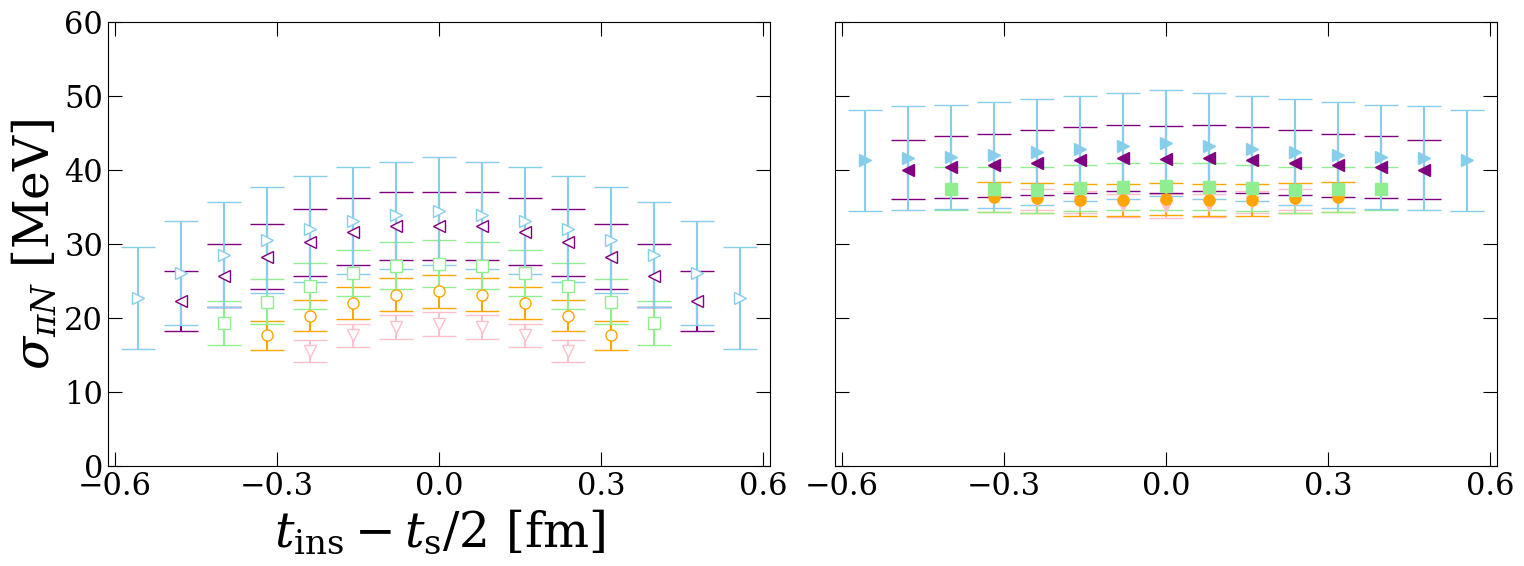

In [13]:
xlim_rainbow=[-0.6,0.6]
xticks_rainbow=[-0.6,-0.3,0,0.3,0.6]
xlabel_rainbow=r'$t_{\mathrm{ins}}-t_{\mathrm{s}}/2$ [fm]'
xlim_fit=[0,0.6]
xticks_fit=[0.1,0.3,0.5,0.7]
xlabel_fit=r'$t_{\mathrm{ins,min}}$ [fm]'



tfs=[8,10,12,14,16]

diags=yu.diags_all #- {'B3pt','W3pt','Z3pt'}
# diags=yu.diags_jLoopless
ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
# ops=['g;0,0,1;G1;a;l1;p','g;0,0,1;G1;N1sgm0,a;l1;p,sgm']

c2ptM=get2ptMat(ops)
c3ptM=[get3ptMat(ops,ops,f'id_j+_{tf}',diags=diags) for tf in tfs]

ratio=[np.real(c3ptM[i_tf][:,:,0,0])/np.real(c2ptM[:,tf,0,0][:,None]) for i_tf,tf in enumerate(tfs)]

# s0=1
# ratioSum=[np.sum(ele[:,s0:-s0],axis=1) for ele in ratio]
# ratioSumDif=[(ratioSum[i+1]-ratioSum[i])/2  for i in range(len(ratioSum)-1)]

# fitfunc=lambda x: np.array([x[0]+x[1]*tf for tf in tfs])
# pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,np.transpose(ratioSum),[-100,50])
# print(np.mean(chi2_jk)/Ndof)

GEVP_t0=3
def func(c2ptM):
    evals,evecs=yu.GEVP(c2ptM,GEVP_t0)
    En=np.log(evals/np.roll(evals,-1,axis=0))
    t=evecs[:,:,0]
    evecs=np.abs(evecs/t[:,:,None])
    res=np.concatenate([En,evecs[:,:,1]],axis=1)
    res=np.real(res)
    return res
resGEVP=yu.jackmap(func,c2ptM)

GEVP_t=14
evec_global=np.array([np.mean(resGEVP[:,GEVP_t,2])])
# evec_global=np.array([0])
def get(i_tf):
    tf=tfs[i_tf]
    # evec=np.array([np.mean(resGEVP[:,16,2])])
    evec=evec_global
    # evec=resGEVP[:,14,2]
    c3pt=c3ptM[i_tf][:,:,0,0]+ evec[:,None]*c3ptM[i_tf][:,:,0,1] + evec[:,None]*c3ptM[i_tf][:,:,1,0]
    c2pt=c2ptM[:,tf,0,0] + evec*c2ptM[:,tf,0,1] + evec*c2ptM[:,tf,1,0] + evec**2*c2ptM[:,tf,1,1] *0
    return np.real(c3pt)/np.real(c2pt)[:,None]

ratioGEVP=[get(i_tf) for i_tf,tf in enumerate(tfs)]


fig, axs = yu.getFigAxs(1,2,sharey=True,sharex=True)
# colorMap_rainbow={('noGEVP',10):'green',('noGEVP',12):'blue',('noGEVP',14):'purple',('noGEVP',16):'brown',('noGEVP',18):'brown',\
#     ('GEVP',10):'yellow',('GEVP',12):'orange',('GEVP',14):'red',('GEVP',16):'pink',('GEVP',18:'brown')}
colorMap_rainbow={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
markerMap={8:'v',10:'o',12:'s',14:'<',16:'>',18:'d',20:'^'}
xunit=ens2a[ens]; yunit=ens2amu[ens]*ens2aInv[ens]


case='noGEVP'
mfc={'noGEVP':'white','GEVP':None}[case]

ax=axs[0,0]
for i_tf,tf in enumerate(tfs):
    color=colorMap_rainbow[tf]
    marker=markerMap[tf]
    mean,err=yu.jackme(ratio[i_tf])
    plt_x=np.arange(1 - tf//2,tf//2)*xunit; plt_y=mean[1:tf]*yunit; plt_yerr=err[1:tf]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker) 
# ax=axs[0,1]
# for i_tf,tf in enumerate(tfs[1:]):
#     color=colorMap_rainbow[(case,tf)]
#     mean,err=yu.jackme(ratioSumDif[i_tf])
#     plt_x=np.array([tf])*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
#     ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc)

# mean,err=yu.jackme(pars_jk)
# plt_x=np.array([11,14])*xunit; plt_y=mean[1]*yunit; plt_error=err[1]*yunit
# ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)


case='GEVP'
mfc={'noGEVP':'white','GEVP':None}[case]
ax=axs[0,1]
for i_tf,tf in enumerate(tfs):
    color=colorMap_rainbow[tf]
    marker=markerMap[tf]
    mean,err=yu.jackme(ratioGEVP[i_tf])
    plt_x=np.arange(1 - tf//2,tf//2)*xunit; plt_y=mean[1:tf]*yunit; plt_yerr=err[1:tf]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker,label=f'{tf}')
    
# ax.legend(loc='upper center',ncol=len(tfs),fontsize=16,framealpha=0)



axs[0,0].set_ylim([0,60])
    
# axs[0,0].set_ylim([15,65])
# axs[0,0].axhline(40,linestyle='--')
# axs[0,0].axhline(60,linestyle='--')

axs[0,0].set_xlabel(xlabel_rainbow,fontsize=35)
axs[0,0].set_xticks(xticks_rainbow)

axs[0,0].set_ylabel(r'$\sigma_{\pi N}$ [MeV]',fontsize=35)
plt.tight_layout()